## Supply Chain Network Design: Martin-Beck Co.

In [1]:
# import Glop package
from ortools.linear_solver import pywraplp as glp
import lptools as lpt

In [2]:
#Create MILP model object
mymodel = glp.Solver('Martin-Beck', glp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

In [3]:
inf = mymodel.infinity()

         # name: supply capacity (thousand tons), fixed cost (thousand $), unit shipping cost ($) to each RDC
source = {'Det': (10, 175, [ 5, 2, 3]),    # Detroit
          'Tol': (20, 300, [ 4, 3, 4]),    # Toledo
          'Den': (30, 375, [ 9, 7, 5]),    # Denver
          'KC':  (40, 500, [10, 4, 2]),    # Kansas City
          'StL': (30,   0, [ 8, 4, 3])}    # Saint Louis

        # name: demand quantity required (thousand tons)
demand = {'Bos':30, 'Atl':20, 'Hou':20}    # Boston, Atlanta, Houston

mymodel.Objective().SetMinimization()    # minimize total plant and transportation cost

In [4]:
# create binary Plant selection variables and a dictionary to access them
select = dict()
for s in source:
    select[s] = mymodel.IntVar(0,1,s)
    (b, f, coeff_lst) = source[s]
    mymodel.Objective().SetCoefficient(select[s], f)

In [5]:
print(select)

{'Det': Det, 'Tol': Tol, 'Den': Den, 'KC': KC, 'StL': StL}


In [6]:
# create shipment variables from Plants to RDCs and a dictionary to access them
ship = dict()
for s in source:
    ship[s] = dict()
    (b, f, coeff_lst) = source[s]
    for (d,c) in zip(demand,coeff_lst):
        ship[s][d] = mymodel.NumVar(0, inf, s + '.' + d)
        mymodel.Objective().SetCoefficient(ship[s][d],c)

In [7]:
print(ship)

{'Det': {'Bos': Det.Bos, 'Atl': Det.Atl, 'Hou': Det.Hou}, 'Tol': {'Bos': Tol.Bos, 'Atl': Tol.Atl, 'Hou': Tol.Hou}, 'Den': {'Bos': Den.Bos, 'Atl': Den.Atl, 'Hou': Den.Hou}, 'KC': {'Bos': KC.Bos, 'Atl': KC.Atl, 'Hou': KC.Hou}, 'StL': {'Bos': StL.Bos, 'Atl': StL.Atl, 'Hou': StL.Hou}}


In [8]:
# create source/supply constraints
for s in source:
    (b,f,coeff_lst) = source[s]
    constr = mymodel.Constraint(-inf, 0, s)
    constr.SetCoefficient(select[s], -b)
    for d in demand:
        constr.SetCoefficient(ship[s][d], 1)

In [9]:
# create demand constraints
for d in demand:
    lb = ub = demand[d]
    constr = mymodel.Constraint(lb,ub,d)
    for s in source:
        constr.SetCoefficient(ship[s][d], 1)

In [10]:
lpt.print_model(mymodel)

Variables:
Det, Tol, Den, KC, StL, Det.Bos, Det.Atl, Det.Hou, Tol.Bos, Tol.Atl, Tol.Hou, Den.Bos, Den.Atl, Den.Hou, KC.Bos, KC.Atl, KC.Hou, StL.Bos, StL.Atl, StL.Hou 

minimize: 175.0*Det + 300.0*Tol + 375.0*Den + 500.0*KC + 5.0*Det.Bos + 2.0*Det.Atl + 3.0*Det.Hou + 4.0*Tol.Bos + 3.0*Tol.Atl + 4.0*Tol.Hou + 9.0*Den.Bos + 7.0*Den.Atl + 5.0*Den.Hou + 10.0*KC.Bos + 4.0*KC.Atl + 2.0*KC.Hou + 8.0*StL.Bos + 4.0*StL.Atl + 3.0*StL.Hou 

Subject To:
Det: - 10.0*Det + 1.0*Det.Bos + 1.0*Det.Atl + 1.0*Det.Hou <= 0.0
Tol: - 20.0*Tol + 1.0*Tol.Bos + 1.0*Tol.Atl + 1.0*Tol.Hou <= 0.0
Den: - 30.0*Den + 1.0*Den.Bos + 1.0*Den.Atl + 1.0*Den.Hou <= 0.0
KC: - 40.0*KC + 1.0*KC.Bos + 1.0*KC.Atl + 1.0*KC.Hou <= 0.0
StL: - 30.0*StL + 1.0*StL.Bos + 1.0*StL.Atl + 1.0*StL.Hou <= 0.0
Bos: 1.0*Det.Bos + 1.0*Tol.Bos + 1.0*Den.Bos + 1.0*KC.Bos + 1.0*StL.Bos = 30.0
Atl: 1.0*Det.Atl + 1.0*Tol.Atl + 1.0*Den.Atl + 1.0*KC.Atl + 1.0*StL.Atl = 20.0
Hou: 1.0*Det.Hou + 1.0*Tol.Hou + 1.0*Den.Hou + 1.0*KC.Hou + 1.0*StL.Hou = 20.

In [11]:
#solve model and display results
status = mymodel.Solve()
print('Solution Status =',status)
print('Optimal Value = %.2f thousand' % mymodel.Objective().Value())
for v in mymodel.variables():
    if v.solution_value() != 0:
        print('%7s = %5.2f' % (v.name(),v.solution_value()))

Solution Status = 0
Optimal Value = 860.00 thousand
     KC =  1.00
    StL =  1.00
 KC.Atl = 20.00
 KC.Hou = 20.00
StL.Bos = 30.00


In [12]:
# display all variable information
print('Variable    LB   Value    UB')
for v in mymodel.variables():
    print('%8s  %5.1f  %5.1f  %5.1f' % (v.name(),v.lb(),v.solution_value(),v.ub()))

Variable    LB   Value    UB
     Det    0.0    0.0    1.0
     Tol    0.0    0.0    1.0
     Den    0.0    0.0    1.0
      KC    0.0    1.0    1.0
     StL    0.0    1.0    1.0
 Det.Bos    0.0    0.0    inf
 Det.Atl    0.0    0.0    inf
 Det.Hou    0.0    0.0    inf
 Tol.Bos    0.0    0.0    inf
 Tol.Atl    0.0    0.0    inf
 Tol.Hou    0.0    0.0    inf
 Den.Bos    0.0    0.0    inf
 Den.Atl    0.0    0.0    inf
 Den.Hou    0.0    0.0    inf
  KC.Bos    0.0    0.0    inf
  KC.Atl    0.0   20.0    inf
  KC.Hou    0.0   20.0    inf
 StL.Bos    0.0   30.0    inf
 StL.Atl    0.0    0.0    inf
 StL.Hou    0.0    0.0    inf


In [13]:
#display constraint information
print('Constraint    LB    Value  UB')
for (c,lhs) in zip(mymodel.constraints(),mymodel.ComputeConstraintActivities()):
    print('%10s  %5.1f  %5.1f  %5.1f' % (c.name(),c.lb(),lhs,c.ub()))

Constraint    LB    Value  UB
       Det   -inf    0.0    0.0
       Tol   -inf    0.0    0.0
       Den   -inf    0.0    0.0
        KC   -inf    0.0    0.0
       StL   -inf    0.0    0.0
       Bos   30.0   30.0   30.0
       Atl   20.0   20.0   20.0
       Hou   20.0   20.0   20.0


### Optimzation Parameter Analysis

In [14]:
import matplotlib.pyplot as plt

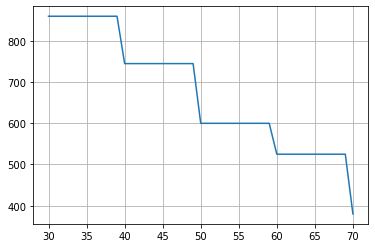

In [15]:
# optimization parameter analysis: St.Louis capacity (30 - 70)

param_lst = list(range(30, 71))
optval_lst = list()
for b in param_lst:
    mymodel.constraints()[4].SetCoefficient(select['StL'], -b)
    mymodel.Solve()
    optval_lst.append(mymodel.Objective().Value())
    
mymodel.constraints()[4].SetCoefficient(select['StL'], -30)

plt.grid()
plt.plot(param_lst,optval_lst)

Step Changes  
30 - KC, StL  
40 - Det, Tol, StL  
50 - Tol, StL  
60 - Det, StL  
70 - StL  

### Logical Constraint

In [16]:
# at least one plant in Detroit or Toledo
new_constr = mymodel.Constraint(1, 2, 'Det_Tol')
new_constr.SetCoefficient(select['Det'], 1)
new_constr.SetCoefficient(select['Tol'], 1)

#solve model and display results
status = mymodel.Solve()
print('Solution Status =',status)
print('Optimal Value = %.2f thousand' % mymodel.Objective().Value())
for v in mymodel.variables():
    if v.solution_value() != 0:
        print('%7s = %5.2f' % (v.name(),v.solution_value()))
            

Solution Status = 0
Optimal Value = 940.00 thousand
    Det =  1.00
    Den =  1.00
    StL =  1.00
Det.Bos = 10.00
Den.Bos = 20.00
Den.Hou = 10.00
StL.Atl = 20.00
StL.Hou = 10.00


### Generating Alternate Solutions

In [17]:
# reset to original optimal solution

# relax the previous logical constraint
new_constr.SetBounds(-mymodel.infinity(), mymodel.infinity())

#solve model and display results
status = mymodel.Solve()
print('Solution Status =',status)
print('Optimal Value = %.2f thousand' % mymodel.Objective().Value())
for v in mymodel.variables():
    if v.solution_value() != 0:
        print('%7s = %5.2f' % (v.name(),v.solution_value()))

Solution Status = 0
Optimal Value = 860.00 thousand
     KC =  1.00
    StL =  1.00
 KC.Atl = 20.00
 KC.Hou = 20.00
StL.Bos = 30.00


In [18]:
# store coefficients and RHS for cut constraint

a = dict()
M = 0
for s in source:
    if select[s].solution_value() == 1:
        a[s] = 1
        M = M+1
    else:    # solution_value == 0
        a[s] = -1
print('M =', M, ', a=', a)

#add cut constraint
cut_constr = mymodel.Constraint(-inf, M-1, 'Cut' + str([a[s] for s in a]))
for s in source:
    cut_constr.SetCoefficient(select[s], a[s])
    
#solve model and display results
status = mymodel.Solve()
print('Solution Status =',status)
print('Optimal Value = %.2f thousand' % mymodel.Objective().Value())
for v in mymodel.variables():
    if v.solution_value() != 0:
        print('%7s = %5.2f' % (v.name(),v.solution_value()))
            
# relax cut constraint
# cut_constr.SetBounds(-mymodel.infinity(),mymodel.infinity())

M = 2 , a= {'Det': -1, 'Tol': -1, 'Den': -1, 'KC': 1, 'StL': 1}
Solution Status = 0
Optimal Value = 940.00 thousand
    Det =  1.00
    Den =  1.00
    StL =  1.00
Det.Bos = 10.00
Den.Bos = 20.00
Den.Hou = 10.00
StL.Atl = 20.00
StL.Hou = 10.00
